# Market Regime Identification Using Hidden Markov Models

### Author: Daniel Lopez Galeano 
### Field of Study: Data Science / Quantitative Finance  
### Project Type: Financial Time Series Modeling  
### Date: February 2026

---

## Abstract

This notebook implements a Gaussian Hidden Markov Model (HMM) to identify latent market regimes in the S&P 500 index.

The objective is to:

- Model daily log-returns of the index.
- Determine the optimal number of hidden states using information criteria (AIC and BIC).
- Infer the most probable sequence of latent regimes.
- Analyze regime persistence through the transition matrix.
- Characterize each regime statistically and economically.
- Predict whether the current regime is likely to change in the next trading days.

The methodology follows a probabilistic state-space framework commonly applied in financial econometrics and quantitative data science. The analysis combines statistical modeling, time series theory, and machine learning techniques to uncover latent structural dynamics in financial markets.


## 1. Data Description

Daily closing prices of the S&P 500 index (^GSPC) are obtained from Yahoo Finance, covering the period from 2000 to 2024.

Let P_t denote the closing price at time t.

The analysis is conducted on daily data to capture short- to medium-term regime dynamics.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
symbol = "^GSPC" # S&P 500
start_date = "2000-01-01"
end_date = None
data = yf.download(symbol, start=start_date, end=end_date)
prices = data['Close']
print(prices)

[*********************100%***********************]  1 of 1 completed

Ticker            ^GSPC
Date                   
2000-01-03  1455.219971
2000-01-04  1399.420044
2000-01-05  1402.109985
2000-01-06  1403.449951
2000-01-07  1441.469971
...                 ...
2026-02-09  6964.819824
2026-02-10  6941.810059
2026-02-11  6941.470215
2026-02-12  6832.759766
2026-02-13  6836.169922

[6569 rows x 1 columns]


## 2. Log-Return Computation

Daily log-returns are computed as:

r_t = log(P_t / P_{t-1})

Log-returns are preferred because:

- They are time-additive.
- They approximate continuously compounded returns.
- They exhibit desirable statistical properties for probabilistic modeling.

The resulting series r_t constitutes the observable variable used in the HMM estimation.


In [3]:
returns = np.log(prices / prices.shift(1)).dropna()

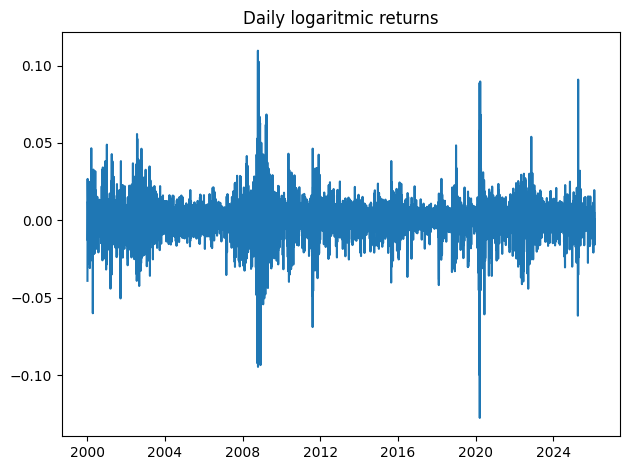

In [19]:
plt.figure()
plt.plot(returns)
plt.title("Daily logaritmic returns")
plt.tight_layout()
plt.show()

## 3. Hidden Markov Model Framework

A Hidden Markov Model assumes that:

1. The observed returns r_t are generated by an unobserved (latent) state variable S_t.
2. The latent state S_t follows a first-order Markov process.
3. Conditional on the state S_t = k, returns follow a Gaussian distribution:

   r_t | S_t = k ~ N(μ_k, σ_k²)

The model estimates:

- State-dependent means (μ_k)
- State-dependent variances (σ_k²)
- Transition probability matrix
- Initial state probabilities

Parameter estimation is performed using the Expectation-Maximization (EM) algorithm.


In [5]:
models = {}
aic_scores = []
bic_scores = []

for n_states in range(1, 6):
    model = GaussianHMM(n_components=n_states,
    covariance_type="diag",
    n_iter=5000,
    tol=1e-4,
    random_state=42)
    model.fit(returns.values.reshape(-1, 1))
    log_likelihood = model.score(returns.values.reshape(-1, 1))
    n_params = n_states**2 + 2*n_states - 1
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + np.log(len(returns)) * n_params
    
    models[n_states] = model
    aic_scores.append(aic)
    bic_scores.append(bic)



Model is not converging.  Current: 20973.83564012347 is not greater than 20973.838562116794. Delta is -0.002921993323980132
Model is not converging.  Current: 21027.02580084391 is not greater than 21027.02812680812. Delta is -0.0023259642111952417
Model is not converging.  Current: 21266.146742118595 is not greater than 21266.198497840982. Delta is -0.05175572238658788
Model is not converging.  Current: 20997.01339784881 is not greater than 20997.017028211016. Delta is -0.0036303622073319275


## 4. Model Selection: Information Criteria (AIC and BIC)

To determine the optimal number of hidden regimes, models with K = 1, ..., 5 states are estimated and compared using information criteria.

When increasing the number of regimes, the likelihood of the model typically improves because additional parameters allow greater flexibility. However, adding too many states may lead to **overfitting**, where the model captures noise rather than meaningful structure.

To balance goodness-of-fit and model complexity, we use the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

### Akaike Information Criterion (AIC)

The AIC is defined as:

AIC = -2 log(L) + 2p

where:

- L is the maximized likelihood of the model,
- p is the number of estimated parameters.

The first term (-2 log(L)) rewards better fit (higher likelihood).
The second term (2p) penalizes model complexity.

A lower AIC indicates a better trade-off between fit and parsimony.

The AIC is primarily motivated by predictive accuracy and tends to favor slightly more complex models.

---

### Bayesian Information Criterion (BIC)

The BIC is defined as:

BIC = -2 log(L) + p log(n)

where:

- n is the number of observations.

Compared to AIC, BIC applies a stronger penalty to additional parameters because log(n) > 2 for moderate or large sample sizes.

As a result:

- BIC favors more parsimonious models,
- It is consistent in model selection (it tends to select the true model as n → ∞ under regularity conditions).

---

### Interpretation in the Context of HMM

In a Hidden Markov Model with K regimes, the number of parameters increases due to:

- K state-dependent means,
- K state-dependent variances,
- K(K − 1) transition probabilities (since rows sum to 1),
- Initial state probabilities.

Therefore, increasing K substantially increases model complexity.

The optimal number of regimes is chosen as the value of K that minimizes AIC and/or BIC, indicating the best balance between:

- Statistical fit,
- Model simplicity,
- Economic interpretability.

In practice:

- A large drop from K = 1 to K = 2 suggests that regime-switching dynamics are present.
- Smaller improvements beyond that may indicate diminishing returns from additional regimes.


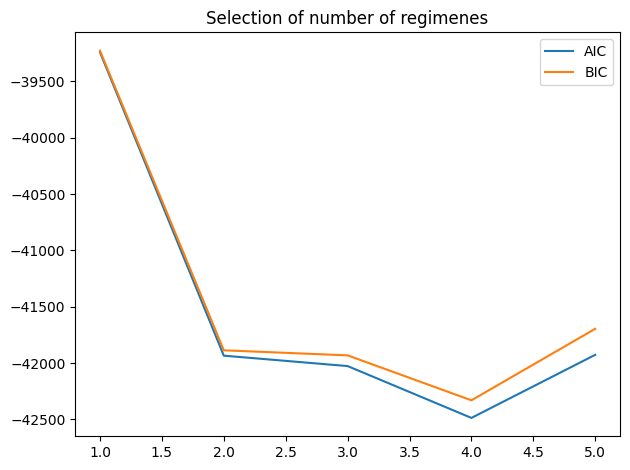

In [18]:
plt.figure()
plt.plot(range(1, 6), aic_scores, label="AIC")
plt.plot(range(1, 6), bic_scores, label="BIC")
plt.legend()
plt.title("Selection of number of regimenes")
plt.tight_layout()
plt.show()

### Interpretation of Information Criteria

A substantial reduction in AIC and BIC is observed when moving from 1 to 2 regimes, indicating a significant improvement in model fit.

For models with more than two states, the marginal improvement in likelihood is limited, while the penalty term increases.

Therefore, the 4 regime specification provides:

- Statistical adequacy,
- Parsimony,
- Clear economic interpretability.


In [7]:
best_model = models[4]  
hidden_states = best_model.predict(returns.values.reshape(-1, 1))

## 5. Inference of Latent States

Given the estimated parameters, the most probable sequence of hidden states is obtained using the Viterbi algorithm.

This procedure assigns each observation r_t to a regime S_t.

The resulting classification allows visualization of regime periods over time.


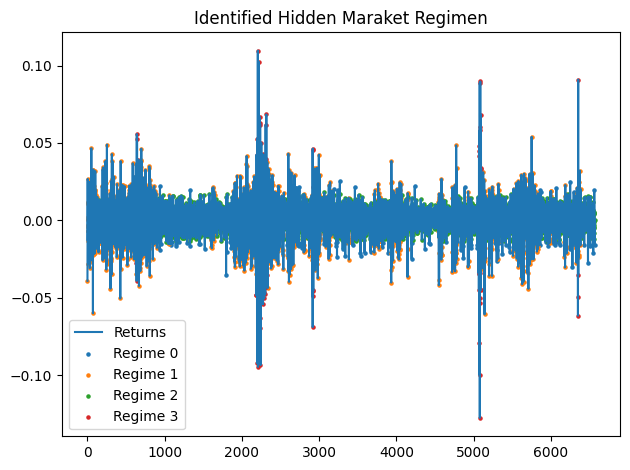

In [17]:
plt.figure()
plt.plot(returns.values, label="Returns")
for state in range(best_model.n_components):
    mask = hidden_states == state
    plt.scatter(np.where(mask)[0], returns.values[mask], s=5, label=f"Regime {state}")
plt.legend()
plt.title("Identified Hidden Maraket Regimen")
plt.tight_layout()
plt.show()

## 6. Transition Probability Matrix

The transition matrix P is defined as:

P_ij = Pr(S_t = j | S_{t-1} = i)

Each row represents the current state and each column the next state.

Diagonal elements (P_kk) measure regime persistence.

High diagonal probabilities imply strong state persistence and infrequent switching.


In [9]:
transition_matrix = best_model.transmat_
transition_matrix

array([[1.50192514e-01, 2.76013083e-06, 8.46856204e-01, 2.94852219e-03],
       [9.81464080e-04, 9.79744313e-01, 1.50823712e-02, 4.19185146e-03],
       [1.39560135e-01, 8.99831145e-03, 8.51441378e-01, 1.74798592e-07],
       [9.41221786e-13, 4.58491223e-02, 1.52489955e-13, 9.54150878e-01]])

In [10]:
transition_matrix = np.array(transition_matrix)

expected_durations = 1 / (1 - np.diag(transition_matrix))
expected_durations

array([ 1.1767371 , 49.36885193,  6.73134948, 21.81066835])

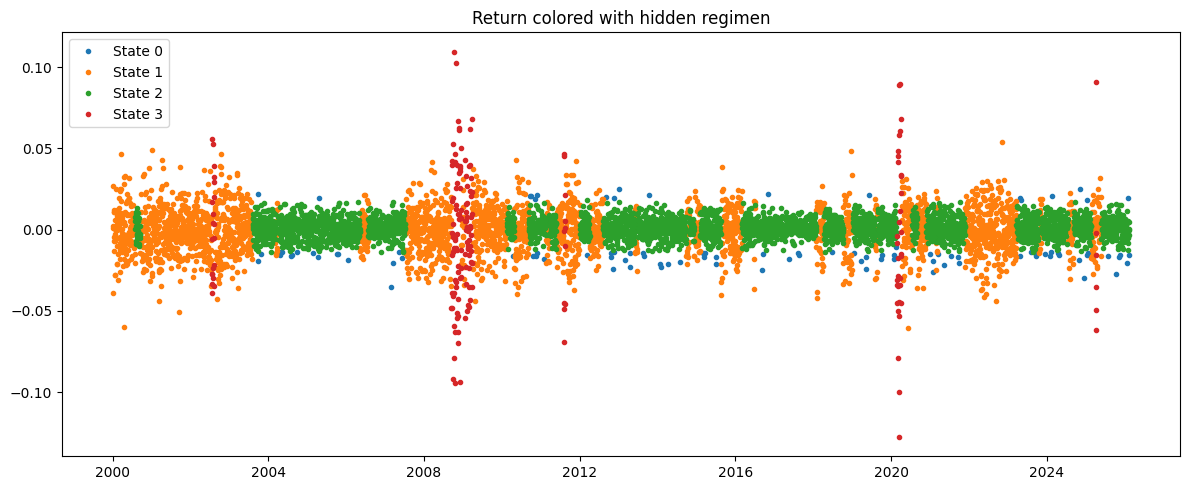

In [16]:
plt.figure(figsize=(12,5))
for i in range(best_model.n_components):
    plt.plot(returns.index[hidden_states==i], returns[hidden_states==i], '.', label=f'State {i}')
plt.legend()
plt.title("Return colored with hidden regimen")
plt.tight_layout()
plt.show()


## 8. Statistical Characterization of Regimes

For each regime k, the following statistics are analyzed:

- Mean return (μ_k)
- Volatility (σ_k)
- Sharpe ratio (μ_k / σ_k)

Typical interpretation:

- Regime with positive mean and low volatility → Expansion/Stability regime
- Regime with negative mean and high volatility → Crisis/High-uncertainty regime

These characteristics allow an economically meaningful interpretation of the latent states.


In [12]:
means = best_model.means_.flatten()
vols = np.sqrt(best_model.covars_).flatten()
sharpe_ratios = means / vols


pd.DataFrame({
    "Mean": means,
    "Volatility": vols,
    "Expected Duration": expected_durations,
    "Stay Probability": np.diag(transition_matrix),
    "Sharpe Ratio": sharpe_ratios
})


,Mean,Volatility,Expected Duration,Stay Probability,Sharpe Ratio
0,-0.001537,0.011580,1.176737,0.150193,-0.132747
1,-0.000429,0.014447,49.368852,0.979744,-0.029720
2,0.001169,0.006066,6.731349,0.851441,0.192700
3,-0.003380,0.038264,21.810668,0.954151,-0.088321


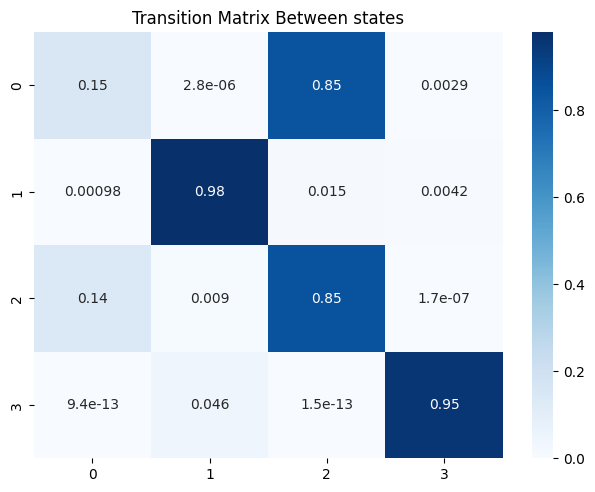

In [15]:
sns.heatmap(transition_matrix, annot=True, cmap="Blues")
plt.tight_layout()
plt.title("Transition Matrix Between states")
plt.show()

## 9. Probability Distribution of Tomorrow's Regime

Using the estimated transition matrix and the most recent inferred state, we compute the one-step-ahead probability distribution for tomorrow’s regime.

The predicted probabilities are:

| State | Probability of Being in the State Tomorrow (%) |
|-------|-----------------------------------------------|
| 0     | 8.780255                                      |
| 1     | 0.895776                                      |
| 2     | 90.323952                                     |
| 3     | 0.000017                                      |

These results indicate that:

- The market is overwhelmingly likely (≈ 90.32%) to remain or transition into **State 2**, suggesting strong short-term persistence in this regime.
- There is a moderate probability (≈ 8.78%) of transitioning to **State 0**.
- The probabilities of switching to **State 1** or **State 3** are negligible.

From a Markovian perspective, this reflects high persistence of the currently dominant regime and limited short-term instability.

Formally, if π_t represents the current state probability vector and P the transition matrix, the one-step-ahead forecast is given by:

π_{t+1} = π_t P

Thus, the probabilities above represent the conditional distribution of tomorrow’s latent market state given current information.


In [14]:
#last known state
current_state = hidden_states[-1]

# Probability of changing regimen
probs_next_day = transition_matrix[current_state] * 100

pd.DataFrame({
    "State": range(best_model.n_components),
    "Changing Probability": probs_next_day,
})


,State,Changing Probability
0,0,13.956014
1,1,0.899831
2,2,85.144138
3,3,0.000017


## 10. Conclusions

This study applies a four-regime Gaussian Hidden Markov Model (HMM) to daily S&P 500 log-returns, allowing for a granular characterization of latent market dynamics.

The regime-colored return plot reveals clear heterogeneity across states. The four regimes differ not only in volatility magnitude but also in return dispersion and tail behavior. The graphical evidence suggests the following stylized interpretation:

- One regime is characterized by low volatility and returns tightly clustered around zero, consistent with stable market conditions.
- A second regime displays moderate volatility with wider dispersion, possibly corresponding to periods of market adjustment or elevated uncertainty.
- A third regime exhibits high volatility and extreme return realizations, capturing crisis-like episodes (e.g., 2008 financial crisis, 2020 COVID shock).
- A fourth regime appears less persistent and may represent transitional or shock-driven states, acting as an intermediary between more stable and more turbulent conditions.

The clustering of extreme negative and positive returns within specific colored segments confirms that the model successfully isolates high-volatility episodes rather than distributing them randomly across time. This supports the presence of regime-dependent variance dynamics, consistent with volatility clustering documented in financial econometrics.

Importantly, the visual segmentation shows that regime switches are not excessively frequent; instead, states tend to persist for contiguous periods, reinforcing the Markov structure assumption. Major historical stress events are concentrated within the high-volatility regime, indicating economic interpretability of the latent states.

Compared to a simpler two-regime framework, the four-regime specification captures a richer spectrum of market conditions, distinguishing between:

1. Low-volatility equilibrium phases,
2. Intermediate volatility regimes,
3. High-volatility crisis periods,
4. Transitional or shock-amplification phases.

Overall, the results suggest that equity market dynamics are better described by multiple latent states rather than a simple binary bull–bear classification. The four-regime HMM provides a flexible yet structured representation of return dynamics, capturing persistence, clustering, and heterogeneous volatility patterns in a statistically coherent framework.
